In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.decomposition import PCA
import random
from sklearn.preprocessing import StandardScaler

#fix random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import os
import pickle
import nltk

In [16]:
#download nltk datasets to this directory
nltk.data.path.append(os.getcwd())
nltk.download('treebank', download_dir=os.getcwd())
nltk.download('brown', download_dir=os.getcwd())
nltk.download('conll2000', download_dir=os.getcwd())

[nltk_data] Downloading package treebank to e:\IITJ\UG third
[nltk_data]     year\semester 6\DL\major\sparsernn...
[nltk_data]   Unzipping corpora\treebank.zip.
[nltk_data] Downloading package brown to e:\IITJ\UG third
[nltk_data]     year\semester 6\DL\major\sparsernn...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package conll2000 to e:\IITJ\UG third
[nltk_data]     year\semester 6\DL\major\sparsernn...
[nltk_data]   Unzipping corpora\conll2000.zip.


True

## Part of speech tagging

In [19]:
from nltk.corpus import treebank, brown, conll2000

In [49]:
treebank_data = treebank.tagged_sents()
brown_data = brown.tagged_sents()
conll2000_data = conll2000.tagged_sents()


In [50]:
dataset = treebank_data + brown_data + conll2000_data

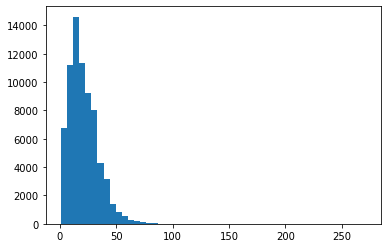

In [51]:
#make histogram of sentence lengths
plt.hist([len(sentence) for sentence in dataset], bins=50)
plt.show()



In [52]:
#remove sentences with length > 50
dataset = [sentence for sentence in dataset if len(sentence) <= 50]

In [53]:
class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<SOS>":0, "<EOS>":1, "<PAD>":2}
        self.index2word = {0:"<SOS>", 1:"<EOS>", 2:"<PAD>"}
        self.word2count = {}
        self.n_words = 3
        self.max_length = 0
    
    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)
        
        if(len(sentence) > self.max_length):
            self.max_length = len(sentence)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [54]:
def word_token_seprator(data):
    x=[]
    y=[]

    for sentence in data:
        x.append([word[0] for word in sentence])
        y.append([word[1] for word in sentence])
    
    return x, y

def word_to_token(dataset,language):
  
    dataset_token = []
   
    for sentence in dataset:
        dataset_token.append([language.word2index[word] for word in sentence])
    
    return dataset_token
    
def pad_dataset(dataset,language,left_padding=True):
    max_length = language.max_length
    if(left_padding):
        for i in range(len(dataset)):
            dataset[i] = [language.word2index["<PAD>"]]*(max_length-len(dataset[i])) + dataset[i]
    else:
        for i in range(len(dataset)):
            dataset[i] = dataset[i] + [language.word2index["<PAD>"]]*(max_length-len(dataset[i]))

    for i in range(len(dataset)):
        dataset[i] = [language.word2index["<SOS>"]] + dataset[i] + [language.word2index["<EOS>"]]

    return dataset

def create_dataset(data):
    x, y = word_token_seprator(data)
    input_lang = Language('input')
    output_lang = Language('tokens')

    for sentence in x:
        input_lang.addSentence(sentence)
    
    for sentence in y:
        output_lang.addSentence(sentence)
    
    x = word_to_token(x, input_lang)
    y = word_to_token(y, output_lang)

    x = pad_dataset(x, input_lang)
    y = pad_dataset(y, output_lang, left_padding=False)

    return x, y, input_lang, output_lang

x, y, input_lang, output_lang = create_dataset(dataset)
    
    

In [56]:
print("Number of sentences in dataset: ", len(x))
print("Number of words in input language: ", input_lang.n_words)
print("Number of words in output language: ", output_lang.n_words)
print("Max length of sentence in dataset: ", input_lang.max_length)


Number of sentences in dataset:  70250
Number of words in input language:  64273
Number of words in output language:  482
Max length of sentence in dataset:  50


## Constituency parsing(work in progress)

In [80]:
from nltk.corpus import treebank
from nltk.tree import ParentedTree

# Load the Treebank dataset
sentences = treebank.parsed_sents()

# Preprocess the dataset for constituency parsing
trees = []
for sent in sentences:
    sent = ParentedTree.convert(sent)
    trees.append(sent)


In [81]:
print(type(trees[0]))

<class 'nltk.tree.parented.ParentedTree'>


In [88]:
#make torch dataset for constituency parsing
class PennTreeBankDataset(Dataset):
    def __init__(self, trees, transform=None):
        self.trees = trees
        self.transform = transform
    
    def __len__(self):
        return len(self.trees)
    
    def __getitem__(self, idx):
        tree = self.trees[idx]
        tree = ParentedTree.convert(tree)
        tree.collapse_unary(collapsePOS=False)
        tree = tree.pformat(margin=1000000)
        tree = tree.split(" ")

        if(self.transform):
            tree = self.transform(tree)
        
        return tree


In [89]:
dataset = PennTreeBankDataset(trees, transform=None)

In [90]:
#print random samples from dataset
for i in range(5):
    print(dataset[random.randint(0, len(dataset))])

['(S', '(NP-SBJ', '(DT', 'The)', '(NN', 'plant))', '(VP', '(MD', 'will)', '(VP', '(VB', 'produce)', '(NP', '(NP', '(NN', 'control)', '(NNS', 'devices))', '(VP', '(VBN', 'used)', '(NP', '(-NONE-', '*))', '(PP-LOC', '(IN', 'in)', '(NP', '(NP', '(NN', 'motor)', '(NNS', 'vehicles))', '(CC', 'and)', '(NP', '(NN', 'household)', '(NNS', 'appliances))))))))', '(.', '.))']
['(S', '(ADVP-TMP', '(NP', '(DT', 'A)', '(NN', 'year))', '(RBR', 'earlier))', '(,', ',)', '(NP-SBJ', '(PRP', 'it))', '(VP', '(VBD', 'had)', '(NP', '(NP', '(NN', 'profit))', '(PP', '(IN', 'of)', '(NP', '(NP', '(QP', '($', '$)', '(CD', '7.5)', '(CD', 'million))', '(-NONE-', '*U*))', '(,', ',)', '(CC', 'or)', '(NP', '(NP', '(CD', '18)', '(NNS', 'cents))', '(NP-ADV', '(DT', 'a)', '(NN', 'share)))))))', '(.', '.))']
['(S', '(NP-SBJ', '(DT', 'The)', '(JJ', 'final)', '(NN', 'vote))', '(VP', '(VBD', 'came)', '(SBAR-TMP', '(IN', 'after)', '(S', '(NP-SBJ', '(DT', 'the)', '(NNP', 'House))', '(VP', '(VP', '(VBD', 'rejected)', '(NP', '(JJ

## Sentiment Analysis IMDB

In [100]:
#import stopwords
from nltk.corpus import stopwords
import re

In [101]:
dataset = pd.read_csv('./IMDB Dataset.csv', encoding='latin-1')
stop_words = set(stopwords.words('english'))

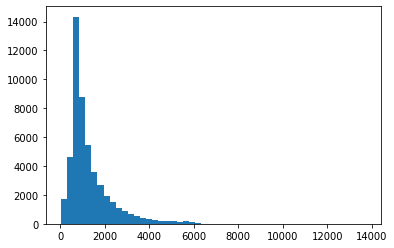

In [126]:
#plot histogram of sentence lengths
plt.hist([len(sentence) for sentence in dataset['review']], bins=50)
plt.show()

In [127]:
#remove sentences with length > 2500
dataset = dataset[[len(sentence) <= 2500 for sentence in dataset['review']]]

In [128]:
def clean_string(s):
    s= re.sub(r"[^\w\s]",'',s)

    s= re.sub(r"\d",'',s)

    s = [word for word in s.split() if len(word) > 3]

    #remove stopwords
    s = [word for word in s if word not in stop_words]
    return s


In [129]:
class Language:
    def __init__(self,name):
        self.name = name
        self.word2index = {"<SOS>":0, "<EOS>":1, "<PAD>":2}
        self.index2word = {0:"<SOS>", 1:"<EOS>", 2:"<PAD>"}
        self.word2count = {}
        self.n_words = 3
        self.max_length = 0
    
    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)
        
        if(len(sentence) > self.max_length):
            self.max_length = len(sentence)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [130]:
def create_dataset(dataset):
    x = []
    y = []
    for i in range(len(dataset)):
        x.append(clean_string(dataset.iloc[i,0]))
        y.append(dataset.iloc[i,1]=='positive')
    
    input_lang = Language('input')

    for sentence in x:
        input_lang.addSentence(sentence)

    x = word_to_token(x, input_lang)
    x = pad_dataset(x, input_lang)

    return x, y, input_lang



x, y, input_lang= create_dataset(dataset)


In [131]:
print(x[0])

[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 10, 21, 22, 23, 24, 25, 26, 27, 23, 28, 29, 30, 31, 20, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 46, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 23, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 90, 92, 93, 94, 95, 14, 6, 96, 16, 97, 98, 99, 100, 101, 102, 103, 104, 56, 105, 106, 20, 20, 107, 108, 109, 110, 111, 112, 113, 110, 114, 115, 116, 117, 118, 119, 120, 113, 121, 49, 122, 123, 124, 125, 49, 126, 127, 128, 129, 130, 131, 132, 133, 134, 1]


In [133]:
print("Number of sentences in dataset: ", len(x))
print("Number of words in input language: ", input_lang.n_words)
print("Max length of sentence in dataset: ", input_lang.max_length)

Number of sentences in dataset:  44660
Number of words in input language:  167714
Max length of sentence in dataset:  240
